In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *
from Adam import Adam
from scipy import integrate
from fourier_1d import *
from scipy.stats import multivariate_normal

In [2]:
x_data = np.load('data/spde_mul_x.npy')
y_data = np.load('data/spde_mul_y.npy')

In [3]:
res = np.zeros((x_data.shape[0],2,x_data.shape[1]-1))
for i in range(x_data.shape[0]):
    res[i,0] = x_data[i,:-1]
    res[i,1] += x_data[i,-1]

In [4]:
x_grid = np.linspace(0, 1, x_data.shape[-1])

ntrain = 900
ntest = 100

batch_size = 50
learning_rate = 0.001

epochs = 500
step_size = 50
gamma = 0.5

modes = 16
width = 64

x_train = res[:ntrain,:,::5]
y_train = y_data[:ntrain,::5]
x_test = res[-ntest:,:,::5]
y_test = y_data[-ntest:,::5]
x_grid = x_grid[::5]

x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train)
x_test = torch.Tensor(x_test)
y_test = torch.Tensor(y_test)


x_train = torch.reshape(x_train,(x_train.shape[0],x_train.shape[2],x_train.shape[1]))
x_test = torch.reshape(x_test,(x_test.shape[0],x_test.shape[2],x_test.shape[1]))

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

model = FNO1d(modes, width,input_num=2).cuda()
print('Total parameters:',count_params(model))

optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

start = default_timer()

MSE = torch.zeros(epochs)
L2 = torch.zeros(epochs)

myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)
        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward()
        
        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()
        
    scheduler.step()
    
    train_mse /= len(train_loader)
    train_l2 /= ntrain
    t2 = default_timer()
    
    MSE[ep] = train_mse
    L2[ep] = train_l2
    print('\repoch {:d}/{:d} L2 = {:.6f}, MSE = {:.6f}, using {:.6f}s'.format(ep+1,epochs,train_l2,train_mse,t2-t1), end='\n', flush=True)

print('Total training time:',default_timer()-start,'s')

Total parameters: 549633
epoch 1/500 L2 = 0.970298, MSE = 0.190097, using 2.605361s
epoch 2/500 L2 = 0.561426, MSE = 0.050928, using 0.136850s
epoch 3/500 L2 = 0.426214, MSE = 0.020766, using 0.124091s
epoch 4/500 L2 = 0.336184, MSE = 0.014468, using 0.121406s
epoch 5/500 L2 = 0.284778, MSE = 0.013664, using 0.123648s
epoch 6/500 L2 = 0.282146, MSE = 0.011838, using 0.122229s
epoch 7/500 L2 = 0.266019, MSE = 0.010432, using 0.121601s
epoch 8/500 L2 = 0.236141, MSE = 0.010670, using 0.124612s
epoch 9/500 L2 = 0.206030, MSE = 0.006692, using 0.120438s
epoch 10/500 L2 = 0.181098, MSE = 0.006032, using 0.123226s
epoch 11/500 L2 = 0.155401, MSE = 0.004805, using 0.124298s
epoch 12/500 L2 = 0.159525, MSE = 0.004737, using 0.120280s
epoch 13/500 L2 = 0.137111, MSE = 0.003727, using 0.122340s
epoch 14/500 L2 = 0.134815, MSE = 0.003616, using 0.123181s
epoch 15/500 L2 = 0.117015, MSE = 0.002733, using 0.121701s
epoch 16/500 L2 = 0.130593, MSE = 0.003195, using 0.122222s
epoch 17/500 L2 = 0.1206

epoch 137/500 L2 = 0.017160, MSE = 0.000115, using 0.121445s
epoch 138/500 L2 = 0.017816, MSE = 0.000111, using 0.122446s
epoch 139/500 L2 = 0.016053, MSE = 0.000104, using 0.124577s
epoch 140/500 L2 = 0.017960, MSE = 0.000106, using 0.123383s
epoch 141/500 L2 = 0.019462, MSE = 0.000118, using 0.122586s
epoch 142/500 L2 = 0.017912, MSE = 0.000110, using 0.121839s
epoch 143/500 L2 = 0.016388, MSE = 0.000119, using 0.121910s
epoch 144/500 L2 = 0.015029, MSE = 0.000090, using 0.119461s
epoch 145/500 L2 = 0.017562, MSE = 0.000102, using 0.123252s
epoch 146/500 L2 = 0.019050, MSE = 0.000119, using 0.124789s
epoch 147/500 L2 = 0.019134, MSE = 0.000120, using 0.122060s
epoch 148/500 L2 = 0.019502, MSE = 0.000127, using 0.122250s
epoch 149/500 L2 = 0.017311, MSE = 0.000098, using 0.123284s
epoch 150/500 L2 = 0.018242, MSE = 0.000101, using 0.123909s
epoch 151/500 L2 = 0.018615, MSE = 0.000103, using 0.123124s
epoch 152/500 L2 = 0.015033, MSE = 0.000090, using 0.120771s
epoch 153/500 L2 = 0.014

epoch 272/500 L2 = 0.010314, MSE = 0.000050, using 0.123151s
epoch 273/500 L2 = 0.010304, MSE = 0.000052, using 0.124572s
epoch 274/500 L2 = 0.010598, MSE = 0.000054, using 0.121155s
epoch 275/500 L2 = 0.010393, MSE = 0.000049, using 0.122625s
epoch 276/500 L2 = 0.010488, MSE = 0.000050, using 0.120563s
epoch 277/500 L2 = 0.010378, MSE = 0.000053, using 0.122013s
epoch 278/500 L2 = 0.010221, MSE = 0.000051, using 0.123729s
epoch 279/500 L2 = 0.010285, MSE = 0.000050, using 0.121946s
epoch 280/500 L2 = 0.010207, MSE = 0.000050, using 0.121293s
epoch 281/500 L2 = 0.010111, MSE = 0.000051, using 0.124323s
epoch 282/500 L2 = 0.010175, MSE = 0.000051, using 0.123709s
epoch 283/500 L2 = 0.010211, MSE = 0.000050, using 0.119889s
epoch 284/500 L2 = 0.010287, MSE = 0.000051, using 0.122966s
epoch 285/500 L2 = 0.010455, MSE = 0.000051, using 0.122118s
epoch 286/500 L2 = 0.010376, MSE = 0.000051, using 0.121123s
epoch 287/500 L2 = 0.010265, MSE = 0.000049, using 0.121646s
epoch 288/500 L2 = 0.010

epoch 407/500 L2 = 0.009383, MSE = 0.000044, using 0.125442s
epoch 408/500 L2 = 0.009387, MSE = 0.000044, using 0.124707s
epoch 409/500 L2 = 0.009421, MSE = 0.000045, using 0.124429s
epoch 410/500 L2 = 0.009400, MSE = 0.000044, using 0.124493s
epoch 411/500 L2 = 0.009369, MSE = 0.000044, using 0.125443s
epoch 412/500 L2 = 0.009398, MSE = 0.000044, using 0.126906s
epoch 413/500 L2 = 0.009357, MSE = 0.000043, using 0.126957s
epoch 414/500 L2 = 0.009377, MSE = 0.000044, using 0.125672s
epoch 415/500 L2 = 0.009383, MSE = 0.000044, using 0.125181s
epoch 416/500 L2 = 0.009366, MSE = 0.000044, using 0.125828s
epoch 417/500 L2 = 0.009388, MSE = 0.000044, using 0.126254s
epoch 418/500 L2 = 0.009386, MSE = 0.000044, using 0.128984s
epoch 419/500 L2 = 0.009379, MSE = 0.000045, using 0.123791s
epoch 420/500 L2 = 0.009380, MSE = 0.000044, using 0.125247s
epoch 421/500 L2 = 0.009372, MSE = 0.000045, using 0.125293s
epoch 422/500 L2 = 0.009415, MSE = 0.000045, using 0.125136s
epoch 423/500 L2 = 0.009

In [5]:
pred = torch.zeros(y_test.shape)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)
index = 0
test_l2 = 0
test_mse = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda(), y.cuda()

        out = model(x).view(-1)
        pred[index] = out
        mse = F.mse_loss(out.view(1, -1), y.view(1, -1), reduction='mean')
        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        test_mse += mse.item()
        index += 1
        
    test_mse /= len(test_loader)
    test_l2 /= ntest
    print('test error: L2 =', test_l2,', MSE =',test_mse)

test error: L2 = 0.01123104093130678 , MSE = 8.16223872618238e-05


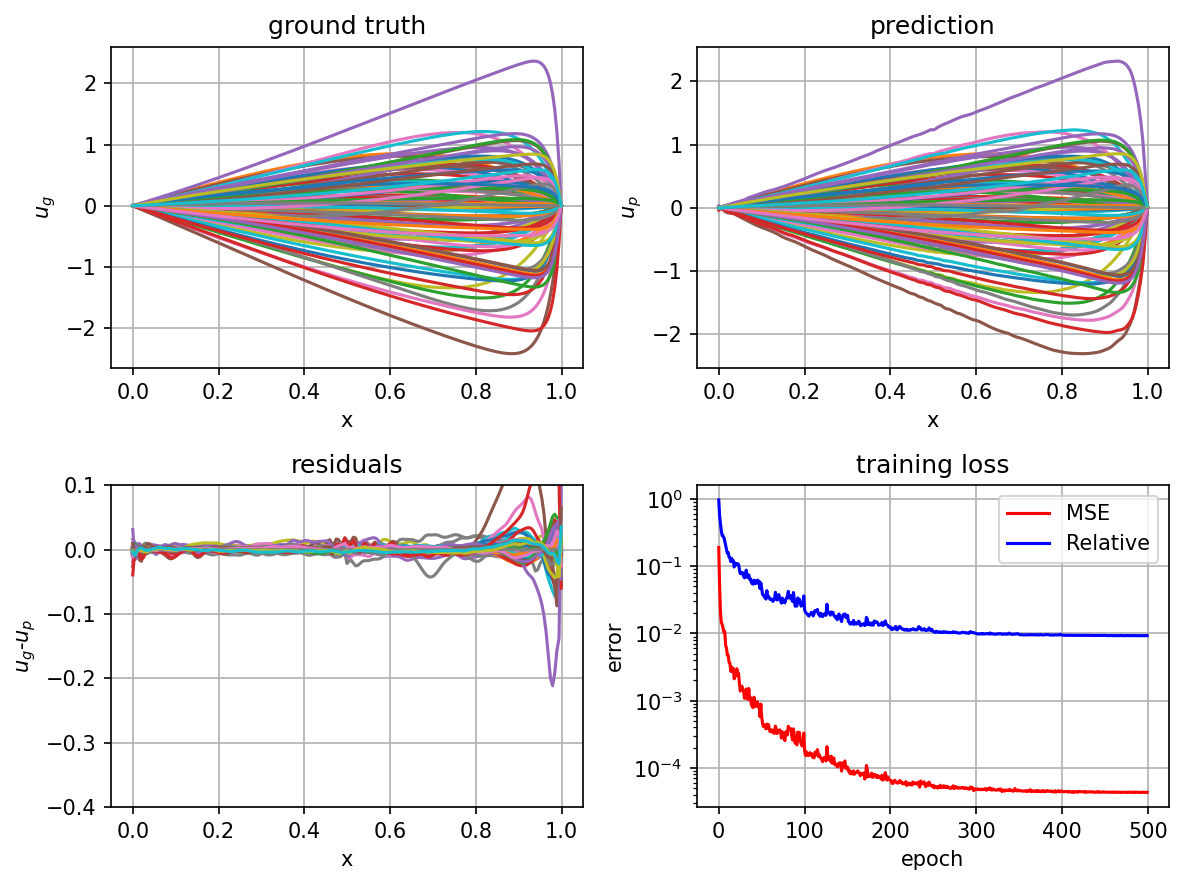

In [6]:
residual = pred-y_test
fig = plt.figure(figsize=(8,6),dpi=150)

plt.subplot(2,2,1)
plt.title("ground truth")
for i in range(ntest):
    plt.plot(x_grid,y_test[i])
plt.xlabel("x")
plt.ylabel("$u_g$")
plt.grid()

plt.subplot(2,2,2)
plt.title("prediction")
for i in range(ntest):
    plt.plot(x_grid,pred[i])
plt.xlabel("x")
plt.ylabel("$u_p$")
plt.grid()

plt.subplot(2,2,3)
plt.title("residuals")
plt.ylim([-0.4,0.1])
for i in range(ntest):
    plt.plot(x_grid,residual[i])
plt.xlabel("x")
plt.ylabel("$u_g$-$u_p$")
plt.grid()
    
plt.subplot(2,2,4)
plt.title("training loss")
plt.plot(MSE,c='r',label='MSE')
plt.plot(L2,c='b',label='Relative')
plt.legend()
plt.yscale('log')
plt.xlabel("epoch")
plt.ylabel("error")
plt.grid()

plt.tight_layout()
plt.show()

In [7]:
v = torch.zeros(ntest)
m = torch.zeros(ntest)
for i in range(ntest):
    v[i] = torch.var(residual[i],unbiased=False)
    m[i] = torch.mean(residual[i])
print(torch.mean(m),torch.mean(v))

tensor(0.0006) tensor(7.4509e-05)


In [8]:
mse = MSE.numpy().reshape(1,MSE.shape[0])
l2 = L2.numpy().reshape(1,L2.shape[0])
loss = np.concatenate((mse,l2))
np.save("data/fno_loss_mul.npy",loss)
torch.save(model,"model/fno_mul")